# Predicting Credit Card Fraud
     This data set is using actual customer data which was collected by the Machine Learning Group at ULB. As a way to conceal customer information, PCA was perfromed on the sensitive
    data in columns V1 to V28 by the provider of the data. The fraud prediction will relly on the following provided features (transaction amount, transaction time, and V1 to V28).
    The class column contains the labels for every observation in the dataset. This dataset doesn't require much cleaning since there are no missing values, which greatly simplifies
    the preprocessing tasks. The labels are given in binary form where 0 indicates no fraud and 1 indicates fraud. The feautre transaction time, indicates the time (seconds) the
    transaction took place in relation to the first sample in the data set.
    
    It's important to first gain an intuition into how our feature set may influenced it's given label. This can be done by simply making some observations as to how each feature could 
    affect its sample's label. Transaction amount could be significant because it tells how much is being transfered when a credit card scam is taking place. Through intuition, it
    seems more likely that credit card fraud when happen with a mdeium to large transaction amount since a scammer isn't very likely to perform a scam for a small reward. Transaction
    time may also be significant because it shows when each transaction took place in relation to each other. Credit card fraud is usually done with multiple transactions which are
    grouped together. Therefore, it seems that multiple credit card transactions happening close to each other would lead to a higher fraud risk. Finally, the feature columns V1 to V28
    don't allow us to give much insight in to what results we might expect. This severly hinders variable selection and other EDA tasks since we can't see how individual features may
    the prediction. While it isn't known, I suspect these columns consist of transaction identifiers such as credit card numbers which may help us correlate different transactions.     
    
    
## Contents
    1. Data Cleaning and Preprocessing
    2. EDA
    3. Modelling and Evaluation
    4. Alternate Models

# Data Cleaning and Preprocessing/EDA

In [21]:
#Loading common libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, train_test_split, StratifiedShuffleSplit, cross_validate
from sklearn.metrics import make_scorer, fbeta_score, average_precision_score,  roc_curve, confusion_matrix, precision_recall_curve, plot_confusion_matrix

import collections
import time
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
random_state=13; #used throughout code to ensure consistent results when the code is rerun

In [2]:
df = pd.read_csv('D:/Desktop/Datasets/creditcard.csv')
#df.head()
#print(df.columns.tolist())

#reorder columns into an easier to understand order
dfColumns=df.columns.tolist();
dfColumns=[dfColumns[-1]]+dfColumns[:-1];
dfColumns=[dfColumns[0]]+[dfColumns[-1]]+dfColumns[1:-1];
df=df[dfColumns];
df.head()

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [4]:
#Search for missing values
print('There are',df.isna().sum().max(),'missing values in the dataframe')
print('The dataset consists of',df.shape[0],'observations')

There are 0 missing values in the dataframe
The dataset consists of 284807 observations


By performing PCA on columns V1 to V28, we are able to confirm that PCA was performed on them because the PCA transformation of this matrix is identical to the matrix provided to it
If desired we can reduce dimensionality by taking out some of the principle components. 
The plot below shows how the usefulness of the feature the higher the principle component is. This will be experimented with further below.


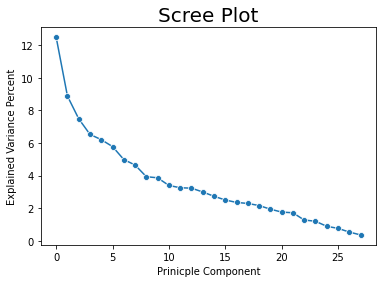

In [7]:
pca = PCA()
X_actual_pca=df.loc[:,'V1':'V28'];
X_verify_pca = pca.fit_transform(df.loc[:,'V1':'V28'])
#print(X_actual_pca.head())
#print(pd.DataFrame(X_verify_pca).head())
print('By performing PCA on columns V1 to V28, we are able to confirm that PCA was performed on them because the PCA transformation of this matrix is identical to the matrix provided to it')
print('If desired we can reduce dimensionality by taking out some of the principle components. \nThe plot below shows how the usefulness of the feature the higher the principle component is. This will be experimented with further below.')

e_var=pca.explained_variance_ratio_; #print(e_var*100)
x_plot=np.linspace(0,len(e_var)-1,num=len(e_var))

fig,ax=plt.subplots()
sns.lineplot(x=x_plot,y=e_var*100,marker="o",ax=ax)
ax.set_title('Scree Plot',fontsize=20);ax.set_xlabel('Prinicple Component');ax.set_ylabel('Explained Variance Percent');
#var_matrix=X_actual_pca.cov();cov_diag=np.diag(var_matrix);print(cov_diag[0]/np.sum(cov_diag));      Verify results of explained variance

No Fraud:  99.83 % of the dataset
Fraud:  0.17 % of the dataset


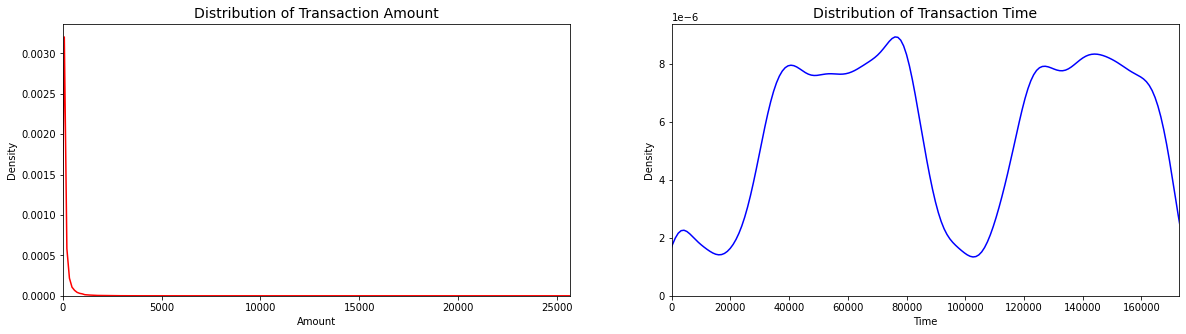

In [8]:

print('No Fraud: ',round(df['Class'].value_counts(normalize=True)[0]*100,2),'% of the dataset');
print('Fraud: ',round(df['Class'].value_counts(normalize=True)[1]*100,2),'% of the dataset');
#print(df['V1'].value_counts(normalize=True,bins=5,dropna=False)); 
fig,ax=plt.subplots(1,2,figsize=(20,5));
sns.kdeplot(df['Amount'],ax=ax[0],color='r');ax[0].set_title('Distribution of Transaction Amount',fontsize=14);ax[0].set_xlim([min(df['Amount']),max(df['Amount'])]);#ax[0].set_ylim([0,2000]);
sns.kdeplot(df['Time'],ax=ax[1],color='b');ax[1].set_title('Distribution of Transaction Time',fontsize=14);ax[1].set_xlim([min(df['Time']),max(df['Time'])]);#ax[1].set_ylim([0,10000]);
#sns.boxplot(x='Amount',data=df,ax=ax[1,0]);sns.boxplot(x='Time',data=df,ax=ax[1,1]);ax[1,0].set_title('Box Plot of Transaction Amount');ax[1,1].set_title('Box Plot of Transaction Time');


From the above observations, several key observations can be made to guide furthersteps. The x-axes are scaled to max/min feature values to show the true scale of the data.
The distribution of transaction amount has a very strong positive skew in the form of an exponential distribution. Because of this we can also conclude that it has some outliers due to this distribution. This makes sense, since a credit card isn't normally used for extremly large purchases.  

The distribution of transaction time lightly follows a bimodal distribution because of the drop in sample points with a transaction time of around 100,000 seconds.

The number of non fraud cases clearly dominates the dataset. Several different sampling techniques will be experimented with in order to improve the preiction so that it doesn't form a bias to predict towards the majority class.

In order to improve predictions we need to scale these features so that one doesn't under/over influence the prediction too much. Our feature set consists of feautures v1 to v28,transaction time, and transaction amount. Features V1 to V28 were transformed as a result of PCA, therefore they are all standardized already. We will used the robustscaler since it is good at influencing outfliers which are affecting the transaction amount feature. It does this by scaling in relation to the IQR

The median of Transaction Amount is 22.0 when unscaled, and 0.0 unscaled
The median of Transaction Time is 84692.0 when unscaled, and 0.0 unscaled
----------------------------------------------------------------------------------------------------
As shown below, this transformation drastically reudces the vairance which increases the sample density due to the reduced variation in transaction amount and time values.
The shape of the distributions for both variables remained unchanged


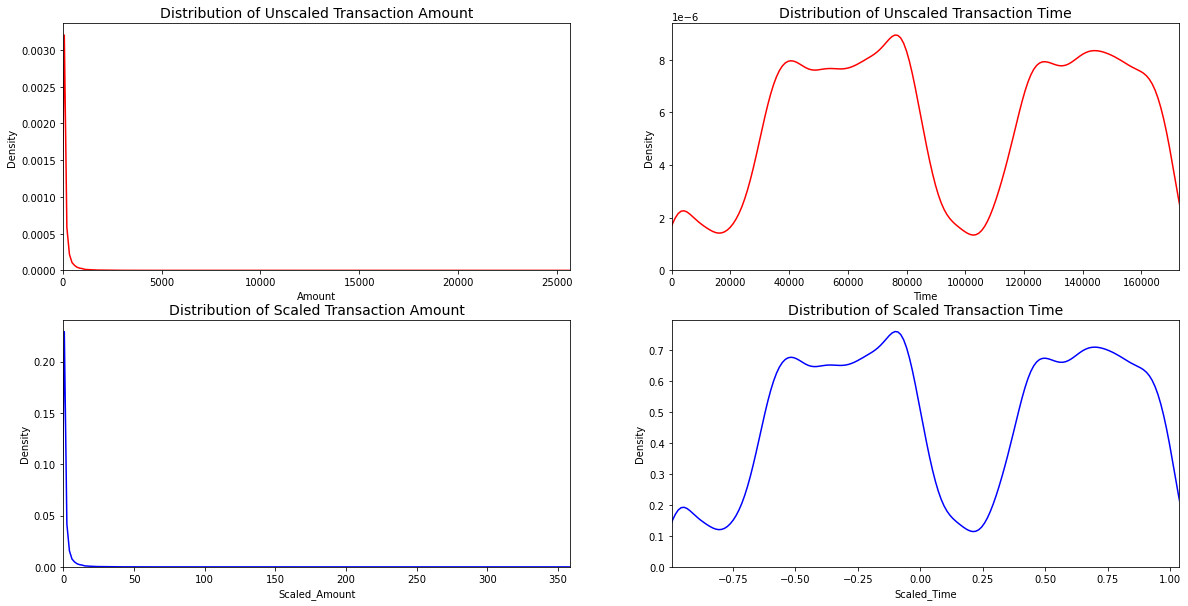

In [10]:
#performing scaling on transaction time and transaction amount
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
rob_scaler=RobustScaler();
UnscaledAmount=df['Amount'];Unscaledtime=df['Time'];
df['Scaled_Amount']= rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Scaled_Time']=rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'],axis=1,inplace=True)           #now put them at the front of the df
ScaledAmount=df['Scaled_Amount'];ScaledTime=df['Scaled_Time'];df.drop(['Scaled_Amount','Scaled_Time'],axis=1,inplace=True);
df.insert(1,'Scaled_Amount',ScaledAmount);df.insert(2,'Scaled_Time',ScaledTime);
#print(df.head())

#plotting
fig,ax=plt.subplots(2,2,figsize=(20,10));
sns.kdeplot(UnscaledAmount,ax=ax[0,0],color='r');ax[0,0].set_title('Distribution of Unscaled Transaction Amount',fontsize=14);ax[0,0].set_xlim([min(UnscaledAmount),max(UnscaledAmount)]);#ax[0].set_ylim([0,2000]);
sns.kdeplot(df['Scaled_Amount'],ax=ax[1,0],color='b');ax[1,0].set_title('Distribution of Scaled Transaction Amount',fontsize=14);ax[1,0].set_xlim([min(df['Scaled_Amount']),max(df['Scaled_Amount'])]);

sns.kdeplot(Unscaledtime,ax=ax[0,1],color='r');ax[0,1].set_title('Distribution of Unscaled Transaction Time',fontsize=14);ax[0,1].set_xlim([min(Unscaledtime),max(Unscaledtime)]);#ax[0].set_ylim([0,2000]);
sns.kdeplot(df['Scaled_Time'],ax=ax[1,1],color='b');ax[1,1].set_title('Distribution of Scaled Transaction Time',fontsize=14);ax[1,1].set_xlim([min(df['Scaled_Time']),max(df['Scaled_Time'])]);

print('The median of Transaction Amount is',np.median(UnscaledAmount),'when unscaled, and',np.median(df['Scaled_Amount']),'unscaled');
print('The median of Transaction Time is',np.median(Unscaledtime),'when unscaled, and',np.median(df['Scaled_Time']),'unscaled');
print('-'*100)
print('As shown below, this transformation drastically reudces the vairance which increases the sample density due to the reduced variation in transaction amount and time values.\nThe shape of the distributions for both variables remained unchanged');

In [11]:
#first perform a simple train/test split before going further to ensure there is no data leakage to the test set

df=df.sample(frac=1,random_state=random_state); #shuffle dataset before split
X=df.drop('Class',axis=1);y=df['Class'];

#Use stratified kfold to ensure we have equal class distribution in each split
fold=StratifiedKFold(n_splits=5,random_state=random_state);
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state);

#The sampling techniques will be performed on the training set while the test set is left untouched in order to provide will do the undersampling on only the training set and then test on the original dataset
# See if both the train and test label distribution are similarly distributed
training_set_label, training_set_counts = np.unique(ytrain, return_counts=True);
test_set_label, test_set_counts=np.unique(ytest, return_counts=True);
print('-'*100);
print('Label Distributions ([No Fraud (0)  Fraud (1)]):');
print('Training Set:',np.round(training_set_counts/len(ytrain),4));print('Test Set:',np.round(test_set_counts/len(ytest),4));
print('This shows that 0\'s and 1\'s take up a similar percentage of both the train and test set.\nThe stratified split worked because both sets of data have the same distribution as the whole set.' );

----------------------------------------------------------------------------------------------------
Label Distributions ([No Fraud (0)  Fraud (1)]):
Training Set: [0.9983 0.0017]
Test Set: [0.9983 0.0017]
This shows that 0's and 1's take up a similar percentage of both the train and test set.
The stratified split worked because both sets of data have the same distribution as the whole set.


No Fraud:  50.0 % of the dataset
Fraud:  50.0 % of the dataset
The randomly undersampled dataset consists of 984 samples. 492 are fraud cases and 492 samples are non fraud cases.


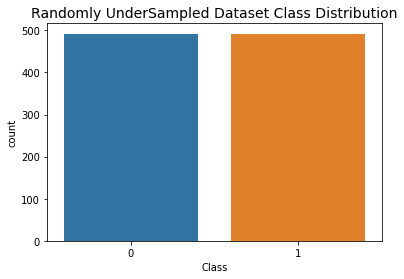

In [12]:
#start with random undersampling since we have train/test set established. This balanced dataset will give us the ability to accurately build a correlation matrix since only a balanced dataset will give accurate correlations
#to see how features are correlated. We will experiemnt with other sampling techniques later on when building models for prediction.(issue with significant undersampling is information loss)

df_FraudSamples=df.loc[df['Class']==1];NumSamples_Frauddf=df_FraudSamples.shape[0];df_NonFraudSamples=df.loc[df['Class']==0][:NumSamples_Frauddf];    #we index the non fraud df to contain the same number of samples as the fraud df so there is a 50/50 split
df_UnderSample=pd.concat([df_FraudSamples,df_NonFraudSamples]); df_UnderSample=df_UnderSample.sample(frac=1,random_state=random_state);
print('No Fraud: ',round(df_UnderSample['Class'].value_counts(normalize=True)[0]*100,2),'% of the dataset');
print('Fraud: ',round(df_UnderSample['Class'].value_counts(normalize=True)[1]*100,2),'% of the dataset');
print('The randomly undersampled dataset consists of',df_UnderSample.shape[0],'samples.',NumSamples_Frauddf,'are fraud cases and',df_NonFraudSamples.shape[0],'samples are non fraud cases.');
plt.figure();sns.countplot(df_UnderSample['Class']);plt.title('Randomly UnderSampled Dataset Class Distribution',fontsize=14);

From this correlation heatmap we can make key observations about how our predictors are correlated to the predicted variable class. We can also see how the predictors are correlated to each other,
this is important for determining if multicollinearity is an issue when building the model. 
Time,V3,V4,V10,V11,V12,and V14 have the highest correlations with the predicted class variable. This indicates that they may have the most impact in predicting the class. For a postive correlation, the higher the predictor is the more likely the predicted class will be fraud, and vice versa for negative correlation
When observing the distribution of the sample points for these highly correlated features, the fraud cases have a wider distribution than than the non fraud cases which might help later in prediction.
The results taken from these plots should only be used to guide further exploration since we assume the random undersample does a good enough job at showing the trends for the whole dataset an

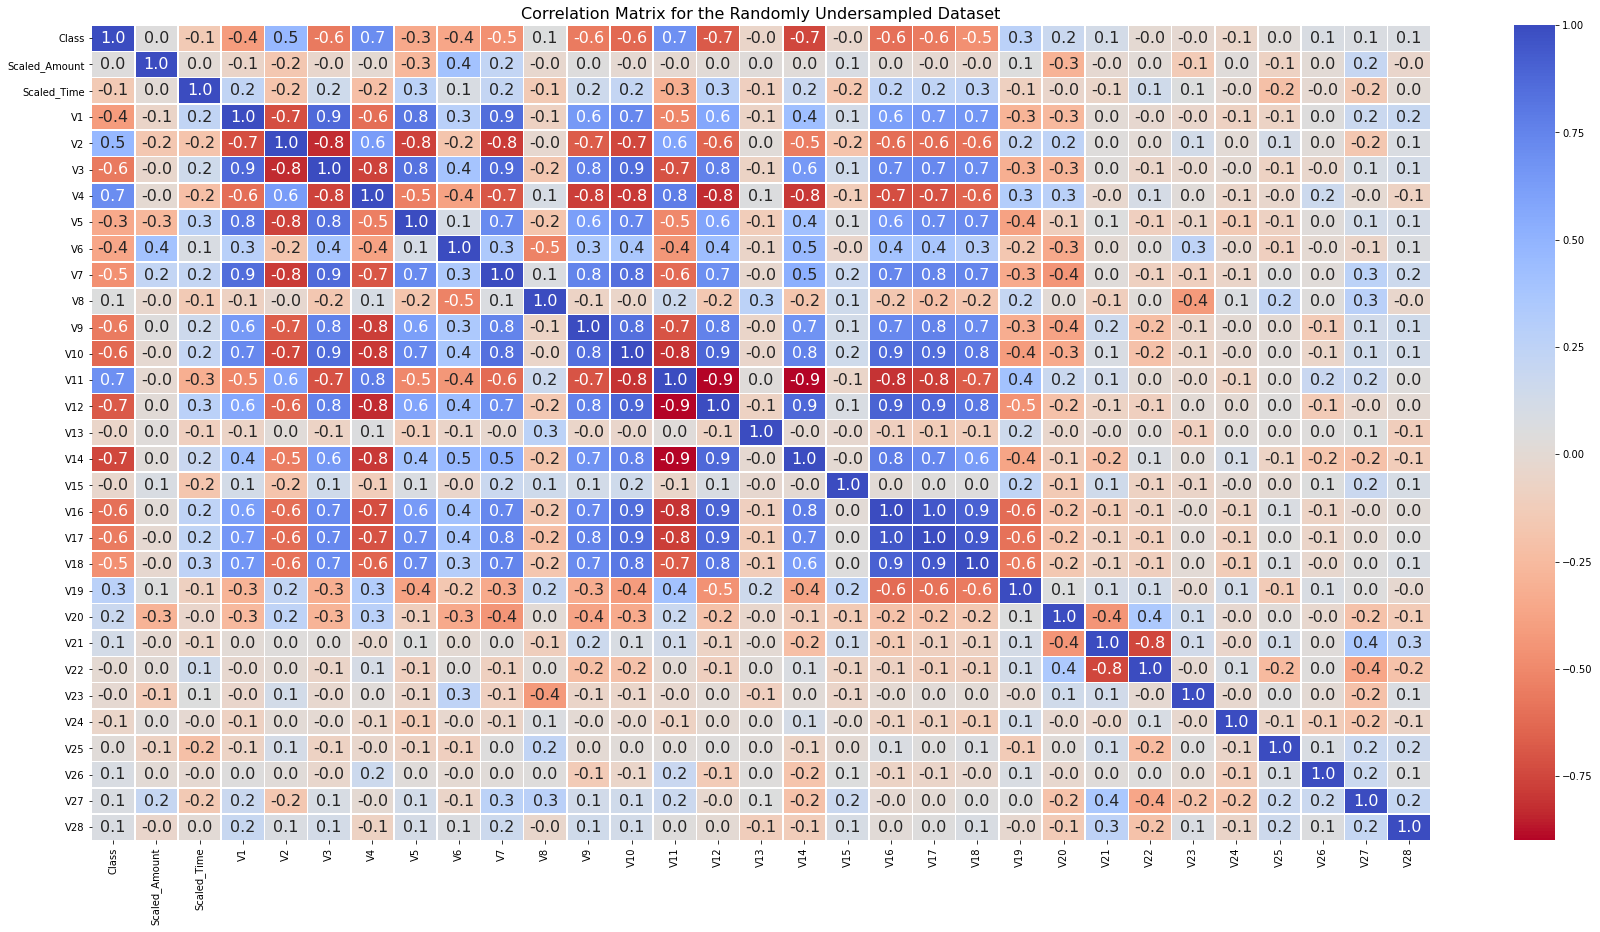

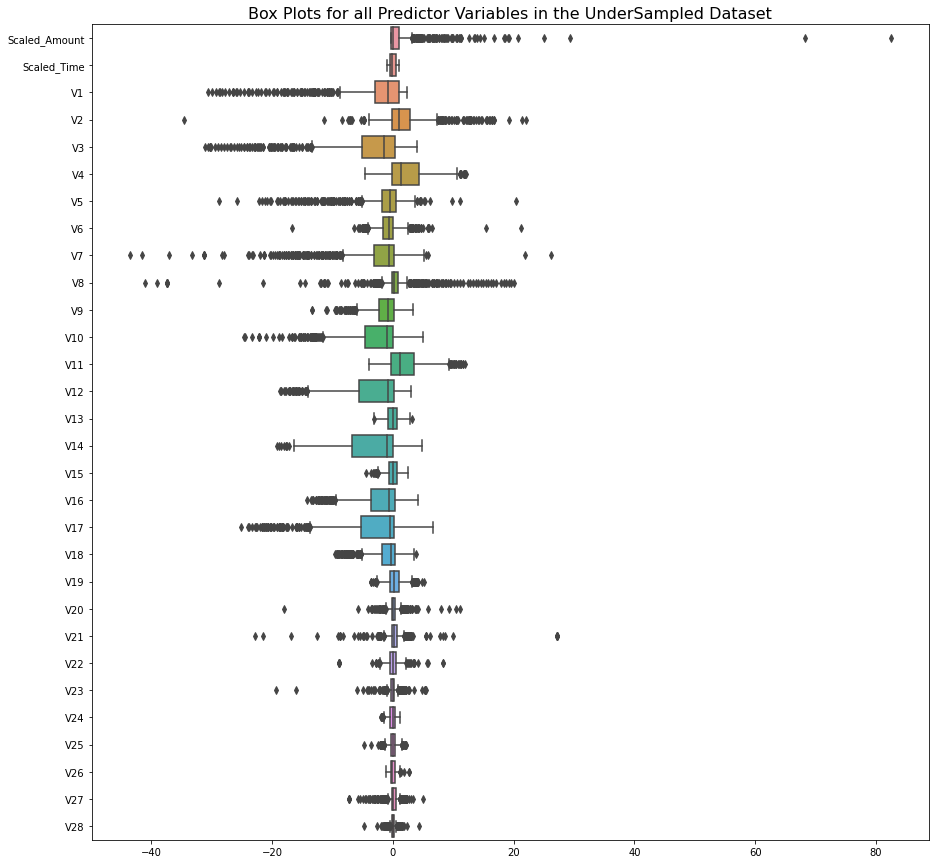

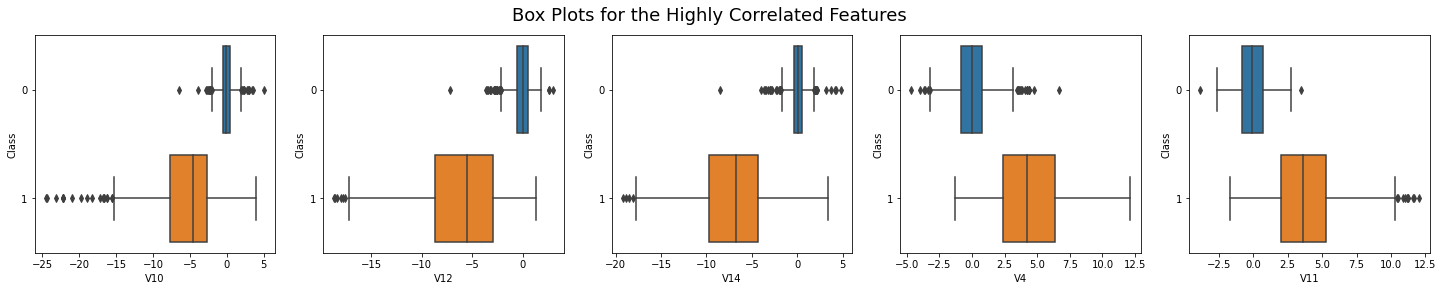

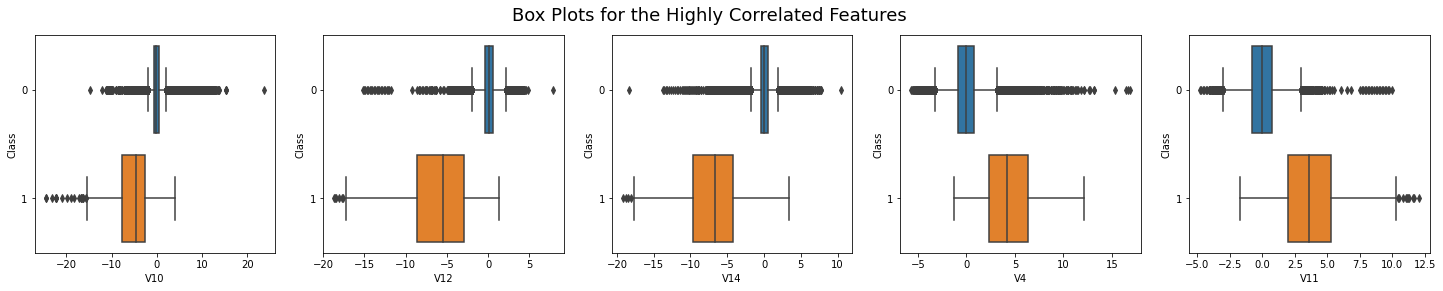

In [38]:
#corelation

#not really the best thing to use since we dont know what the v's are and these already went through PCA so they are already connected and mixed up

#Also importantly shows that  V10, V12 and V14 are negatively correlated with class. The lower these values are, the more likely there will be a fraud transaction.
#V4 and V11 are positively correlated with class. The higher these values are, the more likely there will be a fraud transaction.
#It's also important to look for multicolinearity among preidctors.This isn't an issue for tree based models but is important for logistic regression

f,ax=plt.subplots(1,1,figsize=(30,15));
correlation_matrix=df_UnderSample.corr();sns.heatmap(correlation_matrix,cmap='coolwarm_r',annot=True,annot_kws={'size':16},linewidths=.5,fmt='.1f',ax=ax);ax.set_title('Correlation Matrix for the Randomly Undersampled Dataset',fontsize=16);
print('From this correlation heatmap we can make key observations about how our predictors are correlated to the predicted variable class. We can also see how the predictors are correlated to each other,\nthis is important for determining if multicollinearity is an issue when building the model. ')
print('Time,V3,V4,V10,V11,V12,and V14 have the highest correlations with the predicted class variable. This indicates that they may have the most impact in predicting the class. For a postive correlation, the higher the predictor is the more likely the predicted class will be fraud, and vice versa for negative correlation');

plt.figure(figsize=(15,15));sns.boxplot(data=df_UnderSample.drop(['Class'],axis=1), orient="h"); plt.title('Box Plots for all Predictor Variables in the UnderSampled Dataset',fontsize=16)

f,ax=plt.subplots(1,5,figsize=(25,4));plt.suptitle('Box Plots for the Highly Correlated Features',fontsize=18)
sns.boxplot(x='V10',y='Class',orient='h',data=df_UnderSample,ax=ax[0])
sns.boxplot(x='V12',y='Class',orient='h',data=df_UnderSample,ax=ax[1])
sns.boxplot(x='V14',y='Class',orient='h',data=df_UnderSample,ax=ax[2])
sns.boxplot(x='V4',y='Class',orient='h',data=df_UnderSample,ax=ax[3])
sns.boxplot(x='V11',y='Class',orient='h',data=df_UnderSample,ax=ax[4])
f,ax=plt.subplots(1,5,figsize=(25,4));plt.suptitle('Box Plots for the Highly Correlated Features',fontsize=18)
sns.boxplot(x='V10',y='Class',orient='h',data=df,ax=ax[0])
sns.boxplot(x='V12',y='Class',orient='h',data=df,ax=ax[1])
sns.boxplot(x='V14',y='Class',orient='h',data=df,ax=ax[2])
sns.boxplot(x='V4',y='Class',orient='h',data=df,ax=ax[3])
sns.boxplot(x='V11',y='Class',orient='h',data=df,ax=ax[4])
print('When observing the distribution of the sample points for these highly correlated features, the fraud cases have a wider distribution than than the non fraud cases which might help later in prediction.\nThe results taken from these plots should only be used to guide further exploration since we assume the random undersample does a good enough job at showing the trends for the whole dataset and the features with the prefix V are all connected since PCA was performed on them, therefore they are all connected ');

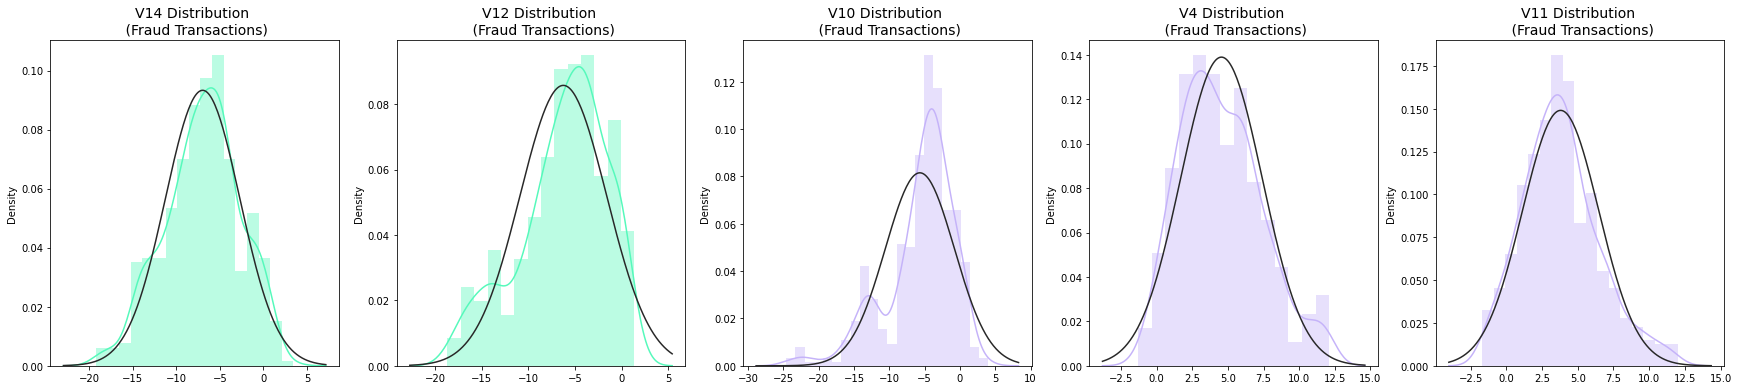

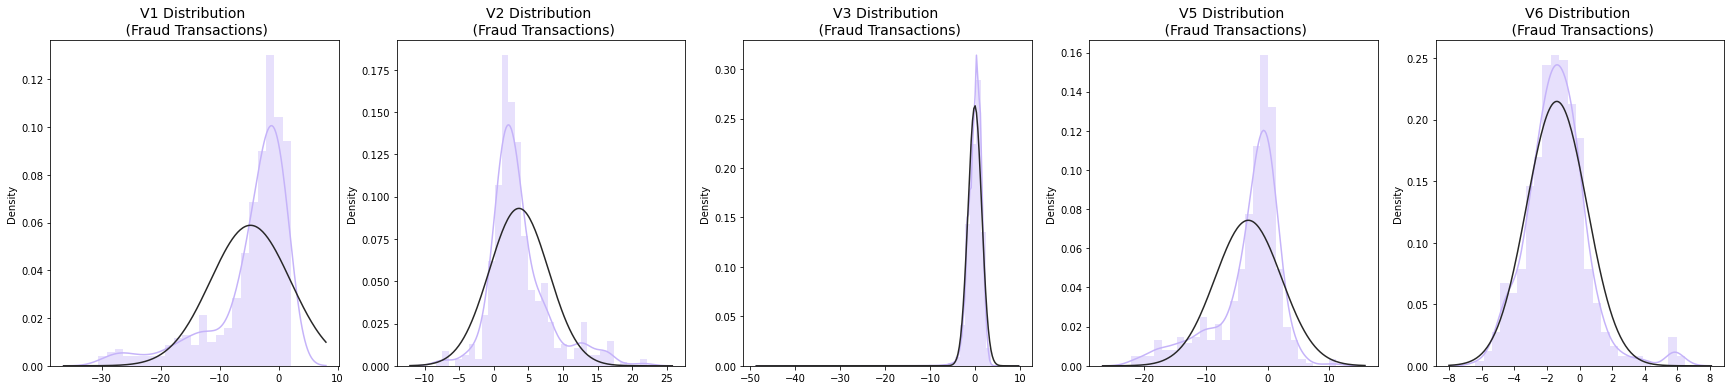

In [43]:
#Extreme Outlier Removal [IN PROGRESS]
#when done this will hopefully boost recall scores

'''
Variables which don't follow normal distribution:
We will choose outliers to remove based on the Interquartile range. This is similar to what is seen in the box plots. The box represents the IQR, and the whiskers represent a threshold of 1.5*IQR

Variables which follow normal distribution:
I will use the standard deviation method and remove based on 2 or 3 standard deviations around the mean

I will perform this on all features which have a corelation greater than 0.3 (V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18)
Removal will only be done on the training set and will only be done on fraud samples. This is because, an outlier fraud example has a large impact on the model.
Hopefully, it's will allow for the model to generalize the trend of the data better for new predictions
''';
from scipy.stats import norm
f,ax=plt.subplots(1,5,figsize=(30,6));
V14_fraud=df['V14'].loc[df['Class']==1].values;sns.distplot(V14_fraud,ax=ax[0],fit=norm,color='#56F9BB');ax[0].set_title('V14 Distribution (Fraud Transactions)',fontsize=12);
V12_fraud=df['V12'].loc[df['Class']==1].values;sns.distplot(V12_fraud,ax=ax[1],fit=norm,color='#56F9BB');ax[1].set_title('V12 Distribution (Fraud Transactions)',fontsize=12);
V10_fraud=df['V10'].loc[df['Class']==1].values;sns.distplot(V10_fraud,ax=ax[2],fit=norm,color='#C5B3F9');ax[2].set_title('V10 Distribution (Fraud Transactions)',fontsize=12);
V4_fraud=df['V4'].loc[df['Class']==1].values;sns.distplot(V4_fraud,ax=ax[3],fit=norm,color='#C5B3F9');ax[3].set_title('V4 Distribution (Fraud Transactions)',fontsize=12);
V11_fraud=df['V11'].loc[df['Class']==1].values;sns.distplot(V11_fraud,ax=ax[4],fit=norm,color='#C5B3F9');ax[4].set_title('V11 Distribution (Fraud Transactions)',fontsize=12);
f,ax=plt.subplots(1,5,figsize=(30,6));
V1_fraud=df['V1'].loc[df['Class']==1].values;sns.distplot(V1_fraud,ax=ax[0],fit=norm,color='#C5B3F9');ax[0].set_title('V1 Distribution (Fraud Transactions)',fontsize=12);
V2_fraud=df['V2'].loc[df['Class']==1].values;sns.distplot(V2_fraud,ax=ax[1],fit=norm,color='#C5B3F9');ax[1].set_title('V2 Distribution (Fraud Transactions)',fontsize=12);
V3_fraud=df['V3'].loc[df['Class']==1].values;sns.distplot(V3_fraud,ax=ax[2],fit=norm,color='#C5B3F9');ax[2].set_title('V3 Distribution (Fraud Transactions)',fontsize=12);
V5_fraud=df['V5'].loc[df['Class']==1].values;sns.distplot(V5_fraud,ax=ax[3],fit=norm,color='#C5B3F9');ax[3].set_title('V5 Distribution (Fraud Transactions)',fontsize=12);
V6_fraud=df['V6'].loc[df['Class']==1].values;sns.distplot(V6_fraud,ax=ax[4],fit=norm,color='#C5B3F9');ax[4].set_title('V6 Distribution (Fraud Transactions)',fontsize=12);
'''f,ax=plt.subplots(1,5,figsize=(30,6));
V7_fraud=df['V7'].loc[df['Class']==1].values;sns.distplot(V7_fraud,ax=ax[0],fit=norm,color='#C5B3F9');ax[0].set_title('V7 Distribution (Fraud Transactions)',fontsize=12);
V9_fraud=df['V9'].loc[df['Class']==1].values;sns.distplot(V9_fraud,ax=ax[1],fit=norm,color='#C5B3F9');ax[1].set_title('V9 Distribution (Fraud Transactions)',fontsize=12);
V16_fraud=df['V16'].loc[df['Class']==1].values;sns.distplot(V16_fraud,ax=ax[2],fit=norm,color='#C5B3F9');ax[2].set_title('V16 Distribution (Fraud Transactions)',fontsize=12);
V17_fraud=df['V17'].loc[df['Class']==1].values;sns.distplot(V17_fraud,ax=ax[3],fit=norm,color='#C5B3F9');ax[3].set_title('V17 Distribution (Fraud Transactions)',fontsize=12);
V18_fraud=df['V18'].loc[df['Class']==1].values;sns.distplot(V18_fraud,ax=ax[4],fit=norm,color='#C5B3F9');ax[4].set_title('V18 Distribution (Fraud Transactions)',fontsize=12);

#V14
v14fraud=newdf['V14'].loc[newdf['Class']==1].values;q25,q75=np.percentile(v14fraud,25),np.percentile(v14fraud,75);
v14iqr=q75-q25
v14cutoff=v14iqr*1.5;v14lower,v14upper=q25-v14cutoff,q75+v14cutoff;
newdf = newdf.drop(newdf[(newdf['V14'] > v14upper) | (newdf['V14'] < v14lower)].index)
#V12
v12fraud=newdf['V12'].loc[newdf['Class']==1].values;q25,q75=np.percentile(v12fraud,25),np.percentile(v12fraud,75);
v12iqr=q75-q25;v12cutoff=v12iqr*1.5;v12lower,v12upper=q25-v12cutoff,q75+v12cutoff;
newdf=newdf.drop(newdf[(newdf['V12'] > v12upper) | (newdf['V12'] < v12lower)].index)
#V10
v10fraud=newdf['V10'].loc[newdf['Class']==1].values;q25,q75=np.percentile(v10fraud,25),np.percentile(v10fraud,75)
v10iqr=q75-q25;v10cutoff=v10iqr*1.5;v10lower,v10upper=q25-v10cutoff,q75+v10cutoff
newdf=newdf.drop(newdf[(newdf['V10'] > v10upper) | (newdf['V10'] < v10lower)].index)
''';

# Modelling and Evaluation
From past work with large unbalanced datasets, I have found randomforests and and xgboost to be the most adaptable and accurate. They are usually my go to algorithms when looking to solve a classification problems
I will be trying the following algorithms:
* Random Forest
* XGBoost
* Multi_Layer Perceptron
* Logistic Regression

I've added the mult-layer perceptron since it is different than the two tree based models. I have also added logistic regression since it is the most straight forward and easiest to explain of the four wwhich will be used.
Research papers puplished by the organization which published the data, suggest that SMOTE with random forest works the best. In their tests, they used random forest along with alot of various other algorithms.
They have not tested it with XGBoost, MLP, or logistic regression. I will test all four along with different sampling methods to see which performs the best.

In [18]:
#This takes a long time to run. Output is pasted below. and the grid search section has been replaced with a simple train to greatly reduce computation time. the grid searched parameters are used. gridsearch section is comment out

#I was able to select the SMOTE sampling method and these paramters after trying several different hyperparamters, grid search methods, feature elimination processes, and sampling methods.
#Using the below process with SMOTE oversampling gave me the best results. I will explore a couple of the different methods I experimented with later to show that they dont perform as well.

#cross validation splits and test/train split (same as above)
fold=StratifiedKFold(n_splits=5,random_state=random_state);
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state);
f2=make_scorer(fbeta_score, beta=2, pos_label=1)
#Initializing Pipeline models
RandomForest_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', RandomForestClassifier(random_state=random_state))]);
MLP_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', MLPClassifier(random_state=random_state))]);
XGB_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', XGBClassifier(random_state=random_state))]);
LogisticRegression_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', LogisticRegression(random_state=random_state))]);

#Normally the below code would be implemented
'''
#Possible parameters for models
RandomForest_Parameters={'classification__n_estimators':[400],'classification__max_depth':[20,50,80,None],'classification__min_samples_leaf': [1, 2, 4],'classification__min_samples_split': [2, 5, 10],'classification__max_features':['auto']};
MLP_Parameters={'classification__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],'classification__activation': ['tanh', 'relu'],'classification__solver': ['sgd', 'adam'],'classification__alpha': [0.0001,0.001,0.01,0.05],'classification__learning_rate': ['constant','adaptive']};
XGB_Parameters={'classification__max_depth':[2,3,4,5,6,7,8,9,10],'classification__learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3],'classification__n_estimators':[100,200,250,300,350,400,500]};
LogisticRegression_Parameters={'classification__penalty': ['l1', 'l2','elasticnet'], 'classification__C': [0.0000001,0.000001,0.000005,0.00001,0.0005,0.0001, 0.001, 0.005, 0.01, 0.1, 1, 10, 100, 1000]};
#GridSearch Initialization with above parameters and pipelines
RandomForest_grid = RandomizedSearchCV(estimator = RandomForest_Model, param_distributions=RandomForest_Parameters, scoring=f2, cv=fold, n_jobs=-1, n_iter=10, return_train_score=True);
MLP_grid = RandomizedSearchCV(estimator = MLP_Model, param_distributions=MLP_Parameters, scoring=f2, cv=fold, n_jobs=-1, n_iter=8,return_train_score=True,random_state=random_state);
XGB_grid = RandomizedSearchCV(estimator = XGB_Model, param_distributions=XGB_Parameters, scoring=f2, cv=fold, n_jobs=-1, n_iter=10,return_train_score=True,random_state=random_state);
LogisticRegression_grid = GridSearchCV(estimator = LogisticRegression_Model, param_grid=LogisticRegression_Parameters, scoring=f2, cv=fold, n_jobs=-1, return_train_score=True);''';

#I am using the below grid search objects which utilized previously gridsearched paramters to reduse computation time on re runs
RandomForest_Parameters={'classification__n_estimators':[400],'classification__max_depth':[50],'classification__min_samples_leaf': [2],'classification__min_samples_split': [5],'classification__max_features':['auto']};
MLP_Parameters={'classification__hidden_layer_sizes': [(50,100,50)],'classification__activation': ['relu'],'classification__solver': ['adam'],'classification__alpha': [0.001],'classification__learning_rate': ['constant']};
XGB_Parameters={'classification__max_depth':[9],'classification__learning_rate':[0.2],'classification__n_estimators':[200]};
LogisticRegression_Parameters={'classification__penalty': ['l2'], 'classification__C': [0.0000001]};

RandomForest_grid = GridSearchCV(estimator = RandomForest_Model, param_grid=RandomForest_Parameters, scoring=f2, cv=fold, n_jobs=-1, return_train_score=True);
MLP_grid = GridSearchCV(estimator = MLP_Model, param_grid=MLP_Parameters, scoring=f2, cv=fold, n_jobs=-1, return_train_score=True);
XGB_grid = GridSearchCV(estimator = XGB_Model, param_grid=XGB_Parameters, scoring=f2, cv=fold, n_jobs=-1, return_train_score=True);
LogisticRegression_grid = GridSearchCV(estimator = LogisticRegression_Model, param_grid=LogisticRegression_Parameters, scoring=f2, cv=fold, n_jobs=-1, return_train_score=True);

#Run the grid search and fit models to get fitted models with the best hyperparameters
RandomForest_grid.fit(Xtrain, ytrain);MLP_grid.fit(Xtrain, ytrain);XGB_grid.fit(Xtrain, ytrain);LogisticRegression_grid.fit(Xtrain, ytrain);

RandomForest_Estimator=RandomForest_grid.best_estimator_;MLP_Estimator=MLP_grid.best_estimator_;XGB_Estimator=XGB_grid.best_estimator_;LogisticRegression_Estimator=LogisticRegression_grid.best_estimator_

#getting cross validation prediction probabilities so ROC and PR plots aren't overfit (also used to calculate PR AUC)
RandomForest_CVpredict = cross_val_predict(RandomForest_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');MLP_CVpredict = cross_val_predict(MLP_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');
XGB_CVpredict = cross_val_predict(XGB_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');LogisticRegression_CVpredict = cross_val_predict(LogisticRegression_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');

#Cross validation scoring 
scoring = {'accuracy','f1','precision','recall','roc_auc'}
scores_RandomForest = cross_validate(RandomForest_Estimator, Xtrain, ytrain, scoring=scoring, cv=fold, return_train_score=True, n_jobs=-1)
scores_MLP = cross_validate(MLP_Estimator, Xtrain, ytrain, scoring=scoring, cv=fold, return_train_score=True, n_jobs=-1)
scores_XGB = cross_validate(XGB_Estimator, Xtrain, ytrain, scoring=scoring, cv=fold, return_train_score=True, n_jobs=-1)
scores_LogisticRegression = cross_validate(LogisticRegression_Estimator, Xtrain, ytrain, scoring=scoring, cv=fold, return_train_score=True, n_jobs=-1)

RandomForest_Recall=scores_RandomForest['test_recall']
RandomForest_Precision=scores_RandomForest['test_precision']
RandomForest_f1=scores_RandomForest['test_f1']
RandomForest_AUC=scores_RandomForest['test_roc_auc']
RandomForest_f2=cross_val_score(RandomForest_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
RandomForest_prAUC=average_precision_score(ytrain, RandomForest_CVpredict[:,1])

MLP_Recall=scores_RandomForest['test_recall']
MLP_Precision=scores_RandomForest['test_precision']
MLP_f1=scores_RandomForest['test_f1']
MLP_AUC=scores_RandomForest['test_roc_auc']
MLP_f2=cross_val_score(MLP_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
MLP_prAUC=average_precision_score(ytrain, MLP_CVpredict[:,1])

XGB_Recall=scores_RandomForest['test_recall']
XGB_Precision=scores_RandomForest['test_precision']
XGB_f1=scores_RandomForest['test_f1']
XGB_AUC=scores_RandomForest['test_roc_auc']
XGB_f2=cross_val_score(XGB_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
XGB_prAUC=average_precision_score(ytrain, XGB_CVpredict[:,1])

LogisticRegression_Recall=scores_RandomForest['test_recall']
LogisticRegression_Precision=scores_RandomForest['test_precision']
LogisticRegression_f1=scores_RandomForest['test_f1']
LogisticRegression_AUC=scores_RandomForest['test_roc_auc']
LogisticRegression_f2=cross_val_score(LogisticRegression_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
LogisticRegression_prAUC=average_precision_score(ytrain, LogisticRegression_CVpredict[:,1])

#The best F2 obtained from the model when run on grid search (this matches the cross validation f2 score)
BestScore_RandomForest=round(RandomForest_grid.best_score_,3)
BestScore_MLP=round(MLP_grid.best_score_,3)
BestScore_XGB=round(XGB_grid.best_score_,3)
BestScore_LogisticRegression=round(LogisticRegression_grid.best_score_,3)

print('Cross-Validated Scores')
print('-'*75);
print('RandomForest')
print('Recall: %0.3f with a standard deviation of %0.3f' % (RandomForest_Recall.mean(), RandomForest_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (RandomForest_Precision.mean(), RandomForest_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (RandomForest_f1.mean(), RandomForest_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (RandomForest_AUC.mean(), RandomForest_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (RandomForest_f2.mean(), RandomForest_f2.std()));
print('PR AUC: %0.3f' % (RandomForest_prAUC));
print(RandomForest_Estimator)
#print('F2: %0.3f' % (BestScore_RandomForest));
print('-'*75);
print('MLP')
print('Recall: %0.3f with a standard deviation of %0.3f' % (MLP_Recall.mean(), MLP_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (MLP_Precision.mean(), MLP_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (MLP_f1.mean(), MLP_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (MLP_AUC.mean(), MLP_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (MLP_f2.mean(), MLP_f2.std()));
print('PR AUC: %0.3f' % (MLP_prAUC));
print(MLP_Estimator);
#print('F2: %0.3f' % (BestScore_MLP));
print('-'*75);
print('XGB')
print('Recall: %0.3f with a standard deviation of %0.3f' % (XGB_Recall.mean(), XGB_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (XGB_Precision.mean(), XGB_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (XGB_f1.mean(), XGB_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (XGB_AUC.mean(), XGB_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (XGB_f2.mean(), XGB_f2.std()));
print('PR AUC: %0.3f' % (XGB_prAUC));
print(XGB_Estimator);
#print('F2: %0.3f' % (BestScore_XGB));
print('-'*75);
print('Logistic Regression')
print('Recall: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_Recall.mean(), LogisticRegression_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_Precision.mean(), LogisticRegression_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_f1.mean(), LogisticRegression_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_AUC.mean(), LogisticRegression_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_f2.mean(), LogisticRegression_f2.std()));
print('PR AUC: %0.3f' % (LogisticRegression_prAUC));
print(LogisticRegression_Estimator);
#print('F2: %0.3f' % (BestScore_LogisticRegression));
print('-'*75);

#here i have tried F2 score since it is good for getting labels and puts a strong influence on recall (AUC can be a bit optimistic)

Prediction_RandomForest=RandomForest_Estimator.predict(Xtest);
Prediction_MLP=MLP_Estimator.predict(Xtest);
Prediction_XGB=XGB_Estimator.predict(Xtest);
Prediction_LogisticRegression=LogisticRegression_Estimator.predict(Xtest);

[22:40:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---------------------------------------------------------------------------
RandomForest
Recall: 0.813 with a standard deviation of 0.022
Precision: 0.883 with a standard deviation of 0.043
F1: 0.846 with a standard deviation of 0.028
AUC: 0.980 with a standard deviation of 0.013
F2: 0.826 with a standard deviation of 0.023
PR AUC: 0.842
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=400,
                                        random_state=13))])
F2: 0.826
--------------------------------------

These results show that the random forest and XGBoost are clearly the two best performing models.

The models were chosen based on the F2 metric. This metric sums both precision and recall while putting an extra weight on recall.
In an imbalanced problem, where false negatives (cases where fraud happens but is not predicted) are costly, a higher F2 score puts an extra emphasis on samples being labeled correctly.

The F2 metric has no insight into how a different classifcatin threshold may affect prediction accuracy (default is 0.5). It only looks at how samples were labeled
The Precision-Recal AUC takes into account the actual probabilities prediction by the classification algorithms. A higher PR AUC means we will have a good balance of precision and recall.
For this problem we want a high recall since we want to predict as many fraud cases correctly as we can, however we don't want precision to drop too low because that means a large majority of cases are predicted fraud when they arent.
This would lead to customer disatisfaction. A high PR AUC ensures we can push the recall high while keeping a reasonably high precision.

Based off the above cross validated metrics, the XGBoost model is the best model. This is because of it's higher PR-AUC and F2 scores. I should be able to push recall to a high value without precisin dropping
Below I will do more tests to prove this observation, on both crossvalidated (on the training set) results and unseens data (test set).


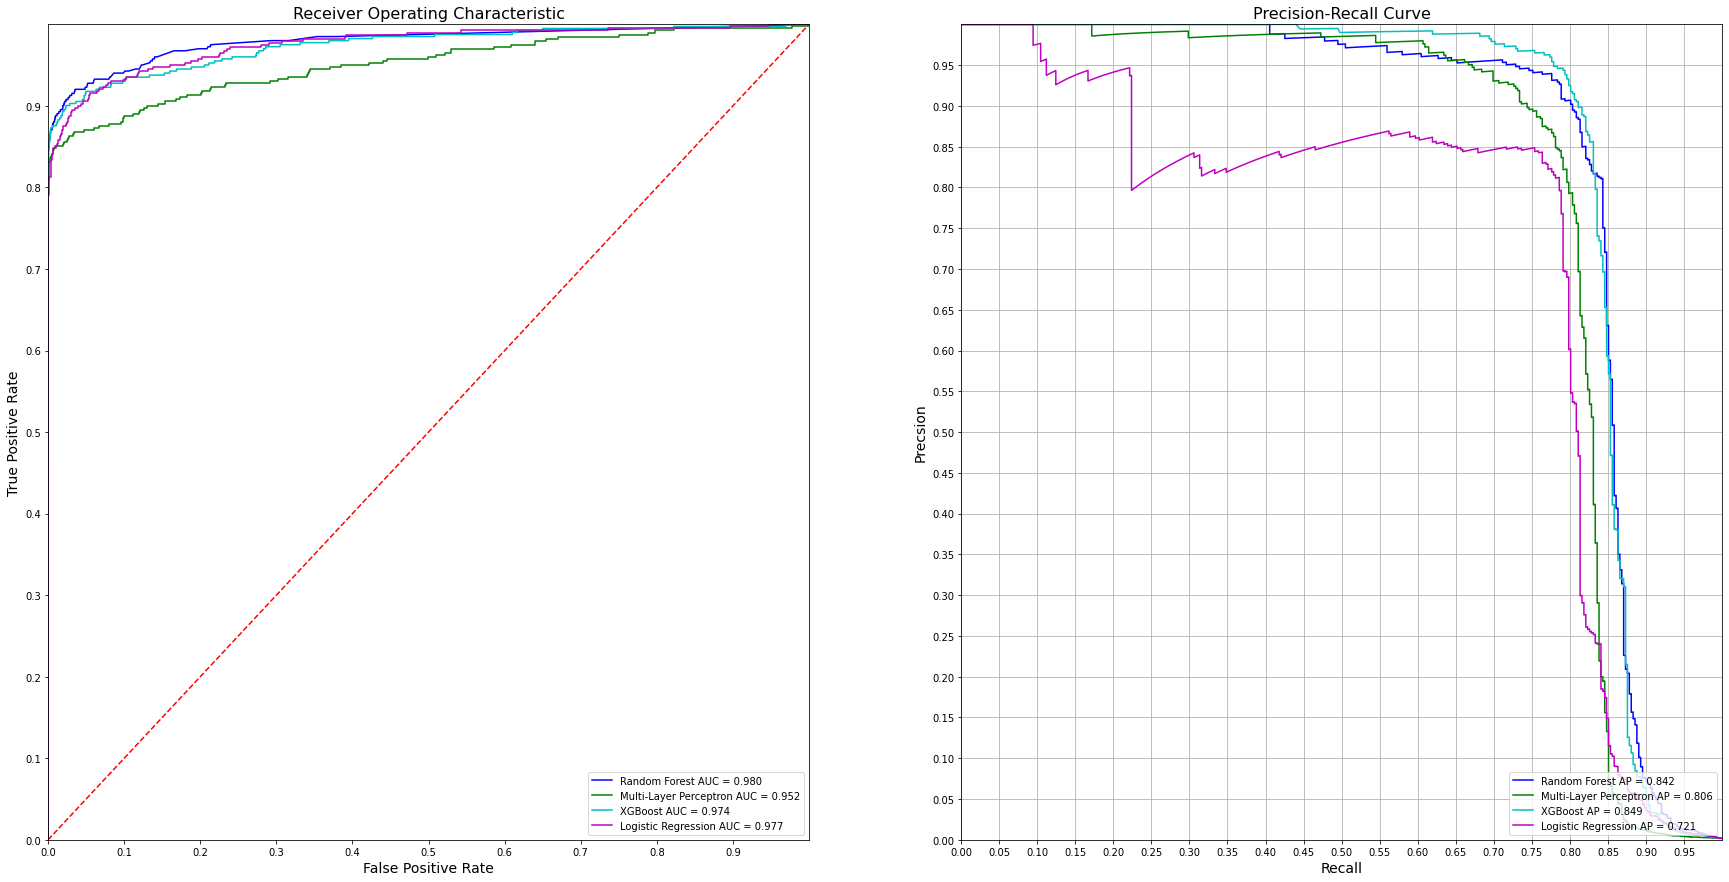

Prediction threshold to be used for desired recall-precision balance (Random Forest): 0.41600000000000015
Prediction threshold to be used for desired recall-precision balance (XGBoost): 0.5829747


In [19]:
#ROC and PR plots (performed on crossvalidated training set)

#ROC
RandomForest_false_positive_rate, RandomForest_true_positive_rate, RandomForest_threshold = roc_curve(ytrain, RandomForest_CVpredict[:,1]);
MLP_false_positive_rate, MLP_true_positive_rate, MLP_threshold = roc_curve(ytrain, MLP_CVpredict[:,1]);
XGB_false_positive_rate, XGB_true_positive_rate, XGB_threshold = roc_curve(ytrain, XGB_CVpredict[:,1]);
LogisticRegression_false_positive_rate, LogisticRegression_true_positive_rate, LogisticRegression_threshold = roc_curve(ytrain, LogisticRegression_CVpredict[:,1]);
fig,ax=plt.subplots(1,2,figsize=(20,10));
ax[0].plot(RandomForest_false_positive_rate, RandomForest_true_positive_rate, 'b', label = 'Random Forest AUC = %0.3f' % RandomForest_AUC.mean());
ax[0].plot(MLP_false_positive_rate, MLP_true_positive_rate, 'g', label = 'Multi-Layer Perceptron AUC = %0.3f' % MLP_AUC.mean());
ax[0].plot(XGB_false_positive_rate, XGB_true_positive_rate, 'c', label = 'XGBoost AUC = %0.3f' % XGB_AUC.mean());
ax[0].plot(LogisticRegression_false_positive_rate, LogisticRegression_true_positive_rate, 'm', label = 'Logistic Regression AUC = %0.3f' % LogisticRegression_AUC.mean());
ax[0].legend(loc = 'lower right');
ax[0].plot([0, 1], [0, 1],'r--');
ax[0].set_xlim([0, 1]);ax[0].set_ylim([0, 1]);
ax[0].set_title('Receiver Operating Characteristic',fontsize=16);
ax[0].set_ylabel('True Positive Rate',fontsize=14);
ax[0].set_xlabel('False Positive Rate',fontsize=14);
ax[0].set_xticks(np.arange(0, 1, step=0.1));
ax[0].set_yticks(np.arange(0, 1, step=0.1));

#PR Curve
RandomForest_PR_precision, RandomForest_PR_recall, RandomForest_threshold_PR = precision_recall_curve(ytrain, RandomForest_CVpredict[:,1]);
MLP_PR_precision, MLP_PR_recall, MLP_threshold_PR = precision_recall_curve(ytrain, MLP_CVpredict[:,1]);
XGB_PR_precision, XGB_PR_recall, XGB_threshold_PR = precision_recall_curve(ytrain, XGB_CVpredict[:,1]);
LogisticRegression_PR_precision, LogisticRegression_PR_recall, LogisticRegression_threshold_PR = precision_recall_curve(ytrain, LogisticRegression_CVpredict[:,1]);
ax[1].plot(RandomForest_PR_recall, RandomForest_PR_precision, 'b', label = 'Random Forest AP = %0.3f' % RandomForest_prAUC.mean());
ax[1].plot(MLP_PR_recall, MLP_PR_precision, 'g', label = 'Multi-Layer Perceptron AP = %0.3f' % MLP_prAUC.mean());
ax[1].plot(XGB_PR_recall, XGB_PR_precision, 'c', label = 'XGBoost AP = %0.3f' % XGB_prAUC.mean());
ax[1].plot(LogisticRegression_PR_recall, LogisticRegression_PR_precision, 'm', label = 'Logistic Regression AP = %0.3f' % LogisticRegression_prAUC.mean());
ax[1].legend(loc = 'lower right');
ax[1].set_xlim([0, 1]);ax[1].set_ylim([0, 1]);
ax[1].set_title('Precision-Recall Curve',fontsize=16);
ax[1].set_ylabel('Precsion',fontsize=14);
ax[1].set_xlabel('Recall',fontsize=14);
ax[1].set_xticks(np.arange(0, 1, step=0.1));
ax[1].set_yticks(np.arange(0, 1, step=0.1));
plt.show();

#Determine the desired prediction threshold from looking at the above PR plot
for i in range(len(RandomForest_threshold_PR)):
    if RandomForest_PR_precision[i]>=0.85:
        Train_prediction_threshold_RandomForest=RandomForest_threshold_PR[i];
        break
print('Prediction threshold to be used for desired recall-precision balance (Random Forest):',round(Train_prediction_threshold_RandomForest,3))
for i in range(len(XGB_threshold_PR)):
    if XGB_PR_precision[i]>=0.85:
        Train_prediction_threshold_XGB=XGB_threshold_PR[i];
        break
print('Prediction threshold to be used for desired recall-precision balance (XGBoost):',round(Train_prediction_threshold_XGB,3))

ROC Plot:
The ROC AUC is clearly higher for both the random forest and logistic regression models than it is for the XGBoost model.
While this is good to know, it's not very helpful in a highly imbalanced problem. This is because the ROC AUC tends to be optimistic
and put emphasis on classes equally.

Precision-Recall Curve:
The plot shows the precisiion recall tradeoff for all four classifiers. As seen, when recall is increased, precision drops.
We want to choose the one that allows us to push the recall as high as pssible without it dropping too low.
The average precision score (also PR AUC) is the highest for XGBoost, so this would be the best decision. 
It should be noted that for some points in the higher recall values, the random forest classifier is able to maintain a higher precision
in comparison to the XGBoost classifier. Since I want recall to be high I may have picked the Random Forest model if there was a more
significant difference. However, I will still choose the XGBoost model due to the small difference and the higher PR AUC score.


Prediction Threshold:
The default prediction threshold for classification is set to p=0.5. Both plots above show the changing values for changing threshold value.
As we move along the line, the prediction threshold is changing. As shown above, I have chosen the threshold value so that precision is kept at 85 percent.
This will give a threshold value which I can use on new unseen data to boost the recall value.

Predicting with the RandomForest took :2.3834731578826904 sec
Predicting with the XGBoost took :0.17253923416137695 sec

XGBoost is able to predict on new data much faster than the random forest can with it's selected hyperparameters.
This is because the Random Forest is using more trees to predict (bagged trees) while XGBoost is using less tress (boosted trees)
Bagged trees are not something which needs to be optimized except for performance vs computation time. This is because, at a certain point, adding more trees wont make the prediction noticeably better. Adding more bagged trees never makes a prediction wores in a Random Forest Model.
Boosted trees are something which needs to be optimized. The optimized value chosen for the highest scoring metric was half the number of trees compared to the random forest
XGBoost also selected a tree max depth of 8 which is much less than what was chosen for the XGBoost model. Each new prediction will have to go down fewer trees and those trees w

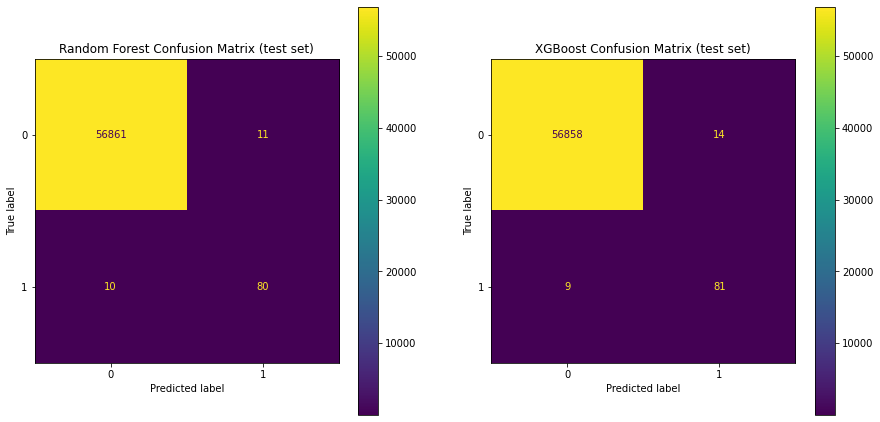

In [30]:
#Test Set Scoring

#test set predictions
t0 = time.time()
Prediction_RandomForest=RandomForest_Estimator.predict(Xtest);
t1 = time.time()
Prediction_XGB=XGB_Estimator.predict(Xtest);
t2 = time.time()
print("Predicting with the RandomForest took :{} sec".format(t1 - t0))
print("Predicting with the XGBoost took :{} sec".format(t2 - t1))
print('')
print('XGBoost is able to predict on new data much faster than the random forest can with it\'s selected hyperparameters.\nThis is because the Random Forest is using more trees to predict (bagged trees) while XGBoost is using less tress (boosted trees)')
print('The grid search also selected a tree max depth of 8 for XGBoost which is much less than what was chosen for the random forest model.\nEach new prediction will have to go down fewer trees and those trees will have fewer levels which greatly reduces computation time')
print('As shown, XGBoost is still able to predict better than the random forest model on this data even with the shorter coputation time.')


#Test Scoring
print('-'*60);print('TEST SET SCORES (Predicting on unseen data)');print('-'*60);print('');
print('No Threshold Adjustment');print('-'*60);
print('Random Forest')
#print('Accuracy:',round(accuracy_score(ytest,Prediction_RandomForest),3))
print('Recall:',round(recall_score(ytest, Prediction_RandomForest),3))
print('Precision:',round(precision_score(ytest,Prediction_RandomForest),3))
print('F1:',round(f1_score(ytest, Prediction_RandomForest),3))
print('F2:',round(fbeta_score(ytest, Prediction_RandomForest, beta=2),3))
print('AUC:',round(roc_auc_score(ytest, Prediction_RandomForest),3))
print('Classification Report:');print(classification_report(ytest,Prediction_RandomForest));
print('-'*60);print('XGBoost');
#print('Accuracy:',round(accuracy_score(ytest,Prediction_XGB),3))
print('Recall:',round(recall_score(ytest, Prediction_XGB),3))
print('Precision:',round(precision_score(ytest,Prediction_XGB),3))
print('F1:',round(f1_score(ytest, Prediction_XGB),3))
print('F2:',round(fbeta_score(ytest, Prediction_XGB, beta=2),3))
print('AUC:',round(roc_auc_score(ytest, Prediction_XGB),3))
print('Classification Report:');print(classification_report(ytest,Prediction_XGB));
                                                      
print('-'*60);print('Threshold Adjustment');print('-'*60);
Prediction_RandomForest_threshold = RandomForest_Estimator.predict_proba(Xtest)[:, 1] > 0.4
print('Random Forest')
#print('Accuracy:',round(accuracy_score(ytest,Prediction_RandomForest_threshold),3))
print('Recall:',round(recall_score(ytest, Prediction_RandomForest_threshold),3))
print('Precision:',round(precision_score(ytest,Prediction_RandomForest_threshold),3))
print('F1:',round(f1_score(ytest, Prediction_RandomForest_threshold),3))
print('F2:',round(fbeta_score(ytest, Prediction_RandomForest_threshold,beta=2),3))
print('AUC:',round(roc_auc_score(ytest, Prediction_RandomForest_threshold),3))
print('Classification Report:');print(classification_report(ytest,Prediction_RandomForest_threshold));
print('-'*60);print('XGBoost')
Prediction_XGB_threshold = XGB_Estimator.predict_proba(Xtest)[:, 1] > 0.6
#print('Accuracy:',round(accuracy_score(ytest,Prediction_XGB_threshold),3))
print('Recall:',round(recall_score(ytest, Prediction_XGB_threshold),3))
print('Precision:',round(precision_score(ytest,Prediction_XGB_threshold),3))
print('F1:',round(f1_score(ytest, Prediction_XGB_threshold),3))
print('F1:',round(fbeta_score(ytest, Prediction_XGB_threshold, beta=2),3))
print('AUC:',round(roc_auc_score(ytest, Prediction_XGB_threshold),3))
print('Classification Report:');print(classification_report(ytest,Prediction_XGB_threshold));print('-'*60);

#Confusion Matrix for every predictor
fig,ax=plt.subplots(1,2,figsize=(15,7.5));
plot_confusion_matrix(RandomForest_Estimator, Xtest, ytest,ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix (test set)", fontsize=12);
plot_confusion_matrix(XGB_Estimator, Xtest, ytest,ax=ax[1])
ax[1].set_title("XGBoost Confusion Matrix (test set)", fontsize=12);

When using the prediction threshold, XGBoost is able to predict on unseen data with 90% recall and 88% percent precision.
This threshold works well for this data. I tried different threshold values and was not able to push recall higher without the precision dropping too low.
The confusion matrix shows how samples are classified. Most of the fraud cases are classified corectly.

This confirms my choice as the XGBoost classifier being the best model for this data. I have selected this as my final model.

---------------------------------------------------------------------------
Final Model
---------------------------------------------------------------------------
Recall: 0.900
Precision: 0.880
F1: 0.890
F2: 0.896
ROC AUC: 0.950
---------------------------------------------------------------------------
Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.90      1.00      0.95      0.91     56872
          1       0.88      0.90      1.00      0.89      0.95      0.89        90

avg / total       1.00      1.00      0.90      1.00      0.95      0.91     56962

---------------------------------------------------------------------------
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               col

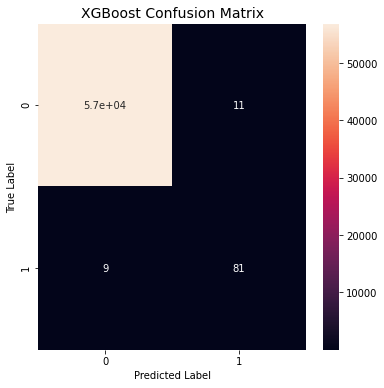

In [40]:
#Conclusion
print('-'*75);print('Final Model');print('-'*75);
finalmodel=XGB_Estimator
#print(accuracy_score(ytest,Prediction_XGB_threshold))
print('Recall: %0.3f' %(recall_score(ytest, Prediction_XGB_threshold)))
print('Precision: %0.3f' %(precision_score(ytest,Prediction_XGB_threshold)))
print('F1: %0.3f' %(f1_score(ytest, Prediction_XGB_threshold)))
print('F2: %0.3f' %(fbeta_score(ytest, Prediction_XGB_threshold,beta=2)))
print('ROC AUC: %0.3f' %(roc_auc_score(ytest, Prediction_XGB_threshold)))
print('-'*75);print('Classification Report:');print(classification_report_imbalanced(ytest,Prediction_XGB_threshold));
print('-'*75);print(finalmodel);print('-'*75);
finalmodel_confusionmatrix = confusion_matrix(ytest, Prediction_XGB_threshold)

fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.heatmap(finalmodel_confusionmatrix, annot=True);
plt.title("XGBoost Confusion Matrix", fontsize=14);
plt.xlabel('Predicted Label');
plt.ylabel('True Label');




# Alternate Models

Below shows the training and testing of two of the many posible models I worked with until I landed on the final model choice which is implemented above.
Each model used only has one difference in comparison to the final model. I also used the final model (XGBoost) with it's optimized parameters on these models.
This will just reduce computation time.

One model uses feature elimination and the other uses near miss undersampling.

In [ ]:
#testing XGBoost (final model) on the data set with some selected feature elimination and with undersampling to show how it doesn't perform as well
#Partial Models
fold=StratifiedKFold(n_splits=5,random_state=random_state);
print('Use feature importances from the previously trained XGBoost model to gather an idea of how many principal components to use. I selected to take off the last 13.')
print('This was done because they dont explain much of the variance in the data (this is shown in the scree plot above). I can only take features off the end because as the principle component increases, the less of the variance a certain feature explains')
print('')
print(XGB_Estimator.steps[1][1].feature_importances_)
Xt=X.drop(['V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'],axis=1)

Xtrain_FeatureElimination, Xtest_FeatureElimination, ytrain_FeatureElimination, ytest_FeatureElimination = train_test_split(Xt, y, test_size=0.2, random_state=random_state);
finalmodel_parameters=XGB_grid.best_params_

#performing both of these without grid search in order to reduce computation. I will use the above selected final model

#Nearmiss Undersampling
finalmodel_undersample = Pipeline([('sampling', NearMiss()),('classification', XGBClassifier(n_estimators=200, max_depth=9, learning_rate=0.2, random_state=random_state))]);
finalmodel_undersample.fit(Xtrain, ytrain);

finalmodel_undersample_CVpredict = cross_val_predict(finalmodel_undersample, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');

finalmodel_undersample_Recall=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='recall',n_jobs=-1)
finalmodel_undersample_Precision=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='precision',n_jobs=-1)
finalmodel_undersample_f1=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='f1',n_jobs=-1)
finalmodel_undersample_AUC=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='roc_auc',n_jobs=-1)
finalmodel_undersample_f2=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
finalmodel_undersample_prAUC=average_precision_score(ytrain, finalmodel_undersample_CVpredict[:,1])

#Feature Elimination and SMOTE sampling
finalmodel_FeatureElimination = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', XGBClassifier(n_estimators=200, max_depth=9, learning_rate=0.2, random_state=random_state))]);
finalmodel_FeatureElimination.fit(Xtrain_FeatureElimination, ytrain_FeatureElimination);

finalmodel_FeatureElimination_CVpredict = cross_val_predict(finalmodel_FeatureElimination, Xtrain_FeatureElimination, ytrain_FeatureElimination, cv=fold, n_jobs=-1, method ='predict_proba');

finalmodel_FeatureElimination_Recall=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='recall',n_jobs=-1)
finalmodel_FeatureElimination_Precision=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='precision',n_jobs=-1)
finalmodel_FeatureElimination_f1=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='f1',n_jobs=-1)
finalmodel_FeatureElimination_AUC=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='roc_auc',n_jobs=-1)
finalmodel_FeatureElimination_f2=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring=f2,n_jobs=-1)
finalmodel_FeatureElimination_prAUC=average_precision_score(ytrain_FeatureElimination, finalmodel_FeatureElimination_CVpredict[:,1])

print('-'*75);
print('Reduced dataset with Nearmiss undersampling');print('-'*75);
print('Recall: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_Recall.mean(), finalmodel_undersample_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_Precision.mean(), finalmodel_undersample_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_f1.mean(), finalmodel_undersample_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_AUC.mean(), finalmodel_undersample_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_f2.mean(), finalmodel_undersample_f2.std()));
print('PR AUC: %0.3f' % (finalmodel_undersample_prAUC));
print('-'*75);print('-'*75);
print('Feature elimination and SMOTE sampling');print('-'*75);
print('Recall: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_Recall.mean(), finalmodel_FeatureElimination_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_Precision.mean(), finalmodel_FeatureElimination_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_f1.mean(), finalmodel_FeatureElimination_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_AUC.mean(), finalmodel_FeatureElimination_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_f2.mean(), finalmodel_FeatureElimination_f2.std()));
print('PR AUC: %0.3f' % (finalmodel_FeatureElimination_prAUC));
print('-'*75);
Prediction_undersample=finalmodel_undersample.predict(Xtest);
Prediction_FeatureElimination=finalmodel_FeatureElimination.predict(Xtest_FeatureElimination);

#Test Scoring (without threshold, below has with chosen threshold)
print('-'*75);print('Test set scores for the feature elimination model');print('-'*75);

print('No Threshold Ajustment:')
print('Accuracy (test):',round(accuracy_score(ytest_FeatureElimination,Prediction_FeatureElimination),3))
print('Recall (test):',round(recall_score(ytest_FeatureElimination,Prediction_FeatureElimination),3))
print('Precision (test):',round(precision_score(ytest_FeatureElimination,Prediction_FeatureElimination),3))
print('F1 (test):',round(f1_score(ytest_FeatureElimination, Prediction_FeatureElimination),3))
print('F2 (test):',round(fbeta_score(ytest_FeatureElimination, Prediction_FeatureElimination, beta=2),3))
print('AUC (test):',round(roc_auc_score(ytest_FeatureElimination, Prediction_FeatureElimination),3))                                                     
#print(classification_report(ytest_FeatureElimination,Prediction_FeatureElimination))                                                    
                                                      
print('Threshold Adjustment:');
Prediction_FeatureElimination_threshold = finalmodel_FeatureElimination.predict_proba(Xtest_FeatureElimination)[:, 1] > 0.6
print('Accuracy (test):',round(accuracy_score(ytest_FeatureElimination,Prediction_FeatureElimination_threshold),3))
print('Recall (test):',round(recall_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold),3))
print('Precision (test):',round(precision_score(ytest_FeatureElimination,Prediction_FeatureElimination_threshold),3))
print('F1 (test):',round(f1_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold),3))
print('F2 (test):',round(fbeta_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold,beta=2),3))
print('AUC (test):',round(roc_auc_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold),3))
#print(classification_report(ytest_FeatureElimination,Prediction_FeatureElimination_threshold))
print('-'*50);
#Confusion Matrix
fig,ax=plt.subplots(1,1,figsize=(4,4));
plot_confusion_matrix(finalmodel_FeatureElimination, Xtest_FeatureElimination, ytest_FeatureElimination,ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix (test set)", fontsize=12);

As shown above, the model using nearmiss did not perform well at all. This is becasue there was a very small number of fraud cases in the data set.
When using undersampling we are forced to have an equal distribution of fraud and non-fraud samples. This means the algorithm isn't alowed to train on many samples.

The idea behind the feature elimination model, was that reducing the principle components with the smallest amount of explained variance would help give a good generalization of the data.
I started by getting feature importanced from the XGBoost model and using the scree plot shown above. I decided it was the best to take off the last 13 principle components.
This model performed well, but not as well as the full model did. Therefore this feature elimination is not justified



## For furthur analysis

* Optimize the cross validation scoring 

* Continue work on extreme outlier elimination in order to improve model performance

* I will attempt to build a tensorflow model to test and compare it's results.

In [45]:
LogisticRegression_grid.best_params_

{'classification__C': 1e-07, 'classification__penalty': 'l2'}